**Instituto Tecnologico de Aeronautica**

**Lab 1 CT-221**: Predição de séries temporais

**Professor**: Paulo Marcelo Tasinaffo

**Equipe**: Victor Hugo de Oliveira Bastos, Leonardo Antônio Lugarini, Marcel Versiani, Rafael Otero

**Local**: São Jose dos Campos

**Data**: Setembro de 2023

>[Preparação dos dados](#scrollTo=PVReDV-SVMVX)

>>[Importando pacotes e dados](#scrollTo=efpR3GuWVMVc)

>>[Calculo do Expoente de Hurst](#scrollTo=LHNzVtsrY7AG)

>>[Aplicando os modelos](#scrollTo=LHNzVtsrY7AG)

>>>[[1] 10-15-1 --- r = 15, p = 0 e tanh / Levenberg-Marquardt](#scrollTo=FUZnaVtqVSCO)

>>>[[2] 10-10-10-1 --- r = 10, p = 10 e Relu / Levenberg-Marquardt](#scrollTo=Uqu36GzdVYh8)

>>>[[3] 10-10-10-3 --- r=10 , p=10, relu / Resilient Backpropapation](#scrollTo=4pekYAa4ae7l)

>>>[[4] 10-25-10 ---  r=25 (RELU) / Polak-Ribiére Conjugate Gradient](#scrollTo=H1UzQr-bVxzV)

>>>[[5] 6-25-25-2 --- r=p=25 Tanh / Bayesian Regularization](#scrollTo=fbGBxtj_XKLv)

>>>[[6] 10-25-25-1, r = p = 25, Tanh / RMSprop](#scrollTo=ziJ-KWiOb50H)

>>[Analisando os resultados](#scrollTo=iA97S80t7h18)



 <a name='prep'></a>
## Preparação dos dados



<a name='imp'></a>
## Importando pacotes e dados

In [1]:
# Importing the necessary Python libraries
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import mplcyberpunk
import seaborn as sns
import plotly.graph_objects as go
from plotly.offline import init_notebook_mode, iplot
import visualkeras
# Importing scipy.stats for Q-Q plots
import scipy.stats as stats
plt.style.use("cyberpunk")

# Importing train_test_split from sklearn.model_selection
from sklearn.model_selection import train_test_split

# Importing OrdinalEncoder from sklearn.compose and sklearn.preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder

# Importing KBinsDiscretizer from sklearn.preprocessing
from sklearn.preprocessing import KBinsDiscretizer

# Importing MinMaxScaler from sklearn.preprocessing
from sklearn.preprocessing import MinMaxScaler

# Importing KNeighborsClassifier from sklearn.neighbors
from sklearn.neighbors import KNeighborsClassifier

# Importing DecisionTreeClassifier from sklearn.tree
from sklearn.tree import DecisionTreeClassifier

# Importing GaussianNB from sklearn.naive_bayes
from sklearn.naive_bayes import GaussianNB

# Importing metrics from sklearn.metrics
from sklearn.metrics import (
    accuracy_score,
    recall_score,
    precision_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    f1_score,
    classification_report,
    roc_curve,
    roc_auc_score
)

# Importing GridSearchCV from sklearn.model_selection
from sklearn.model_selection import GridSearchCV

# Importing PowerTransformer and FunctionTransformer from sklearn.preprocessing
from sklearn.preprocessing import PowerTransformer, FunctionTransformer

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
#from keras.utils.vis_utils import plot_model
from keras.utils import plot_model
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")


Por conveniência, optou-se por adquirir os dados a partir da leitura do Google Drive.

In [2]:
# Carregando os dados...

def carregar_dados(url):
  # URL dos arquivos CSV
  url_data = url
  # Extração do identificador do arquivo da URL
  identificador = url.split('/')[-2]
  # Construção do link de download direto do arquivo
  url_download = 'https://drive.google.com/uc?id=' + identificador

  #Retorna dataframe
  return pd.read_csv(url_download, on_bad_lines='skip', sep=',',parse_dates=['Date'], index_col=['Date'])


# URL dos arquivos CSV
url_data_embr = 'https://drive.google.com/file/d/1JkBgws5aVCpP9Xunv_51Pkhv8QdM6ZKT/view?usp=drive_link'
url_data_petr = 'httpsn://drive.google.com/file/d/1tvv9iIqA9bOpR31c545e59oOzbkXxmpv/view?usp=drive_link'
url_data_vale = 'https://drive.google.com/file/d/1JxYLJ9EQHnN0XGUmOBdd7as_EDsV9CKX/view?usp=drive_link'

embr = carregar_dados(url_data_embr)
petr = carregar_dados(url_data_petr)
vale = carregar_dados(url_data_vale)

companies = dict({'Petr':petr, 'Embr':embr, 'Vale':vale})

In [3]:
#Exibindo dataset
petr.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-01-02,16.990000,17.330000,16.980000,17.330000,6.917481,4488000
2018-01-03,17.240000,17.670000,17.209999,17.549999,7.005296,9771700
2018-01-04,17.670000,17.900000,17.629999,17.700001,7.065169,6816500
2018-01-05,17.690001,17.850000,17.600000,17.840000,7.121052,4646500
2018-01-08,17.639999,18.120001,17.610001,18.120001,7.232818,4763400


<a name='ana'></a>
## Calculo do Expoente de Hurst

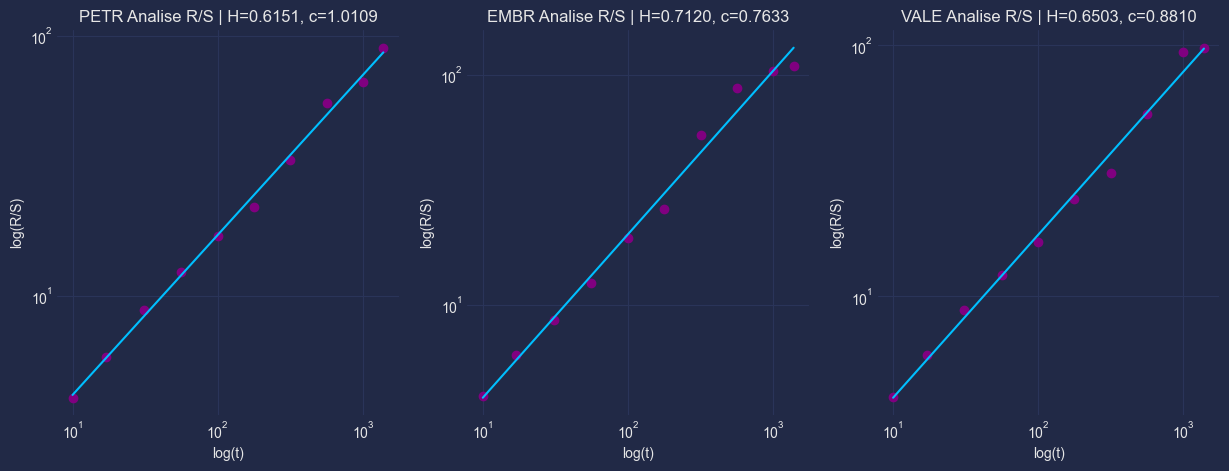

In [109]:
#calculo de expoente de hurst

from hurst import compute_Hc, random_walk

H_petr, c_petr, data_petr = compute_Hc(petr.Close, kind='price', simplified=True)
H_embr, c_embr, data_embr = compute_Hc(embr.Close, kind='price', simplified=True)
H_vale, c_vale, data_vale = compute_Hc(vale.Close, kind='price', simplified=True)

# Plot
figs, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].plot(data_petr[0], c_petr*data_petr[0]**H_petr, color="deepskyblue")

axs[0].scatter(data_petr[0], data_petr[1], color="purple")
axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].set_xlabel('log(t)')
axs[0].set_ylabel('log(R/S)')
axs[0].set_title("PETR Analise R/S | H={:.4f}, c={:.4f}".format(H_petr,c_petr))
axs[0].grid(True)

axs[1].plot(data_embr[0], c*data_embr[0]**H_embr, color="deepskyblue")

axs[1].scatter(data_embr[0], data_embr[1], color="purple")
axs[1].set_xscale('log')
axs[1].set_yscale('log')
axs[1].set_xlabel('log(t)')
axs[1].set_ylabel('log(R/S)')
axs[1].set_title("EMBR Analise R/S | H={:.4f}, c={:.4f}".format(H_embr,c_embr))
axs[1].grid(True)

axs[2].plot(data_vale[0], c_vale*data_vale[0]**H_vale, color="deepskyblue")

axs[2].scatter(data_vale[0], data_vale[1], color="purple")
axs[2].set_xscale('log')
axs[2].set_yscale('log')
axs[2].set_xlabel('log(t)')
axs[2].set_ylabel('log(R/S)')
axs[2].set_title("VALE Analise R/S | H={:.4f}, c={:.4f}".format(H_vale,c_vale))
axs[2].grid(True)


plt.show()

<a name='ana'></a>
## Aplicando os modelos

In [6]:
#Separando os últimos 90 registros
petr_close = petr[:-90]['Close']
embr_close = embr[:-90]['Close']
vale_close = vale[:-90]['Close']

In [7]:
date_index  = petr[-90:].index

<a name='ana'></a>
###[1] 10-15-1 --- r = 15, p = 0 e tanh / Levenberg-Marquardt

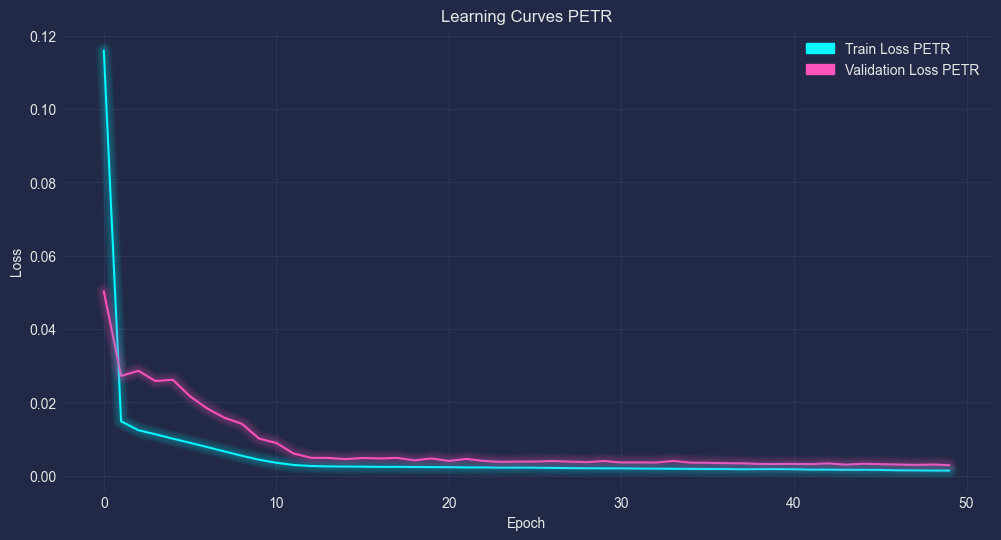

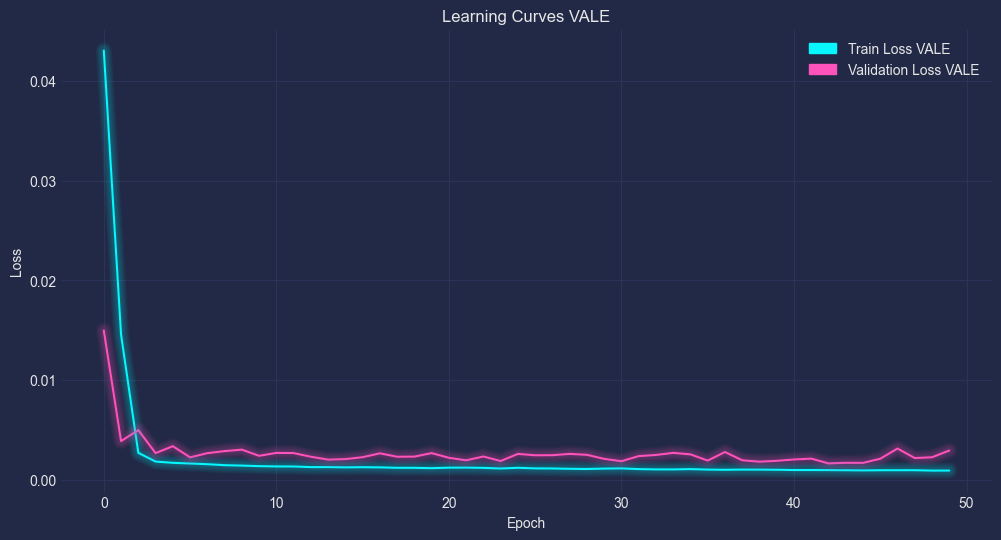

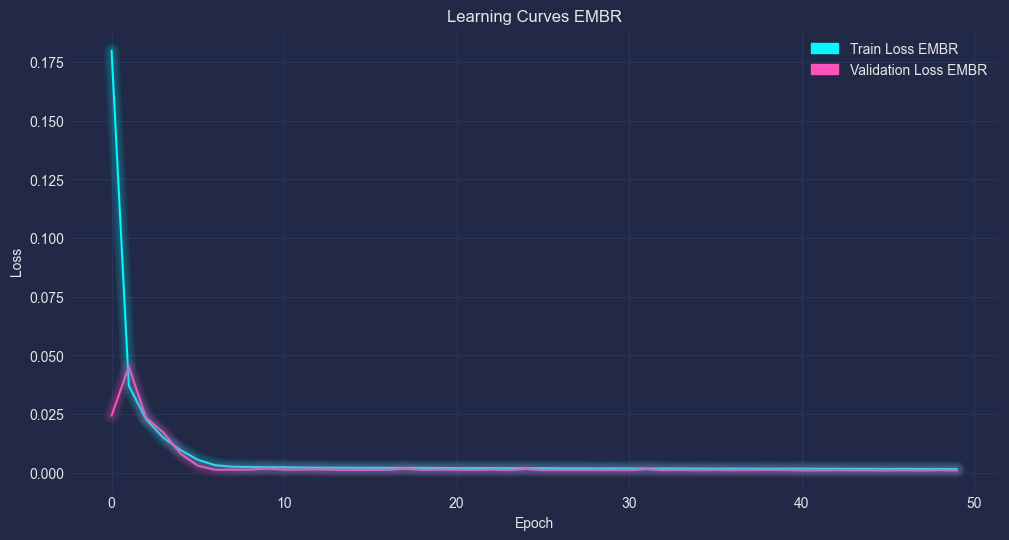

In [8]:
r_1 = 15
p_1 = 0

# Função para criar amostras NARMAX
def create_narmax_samples(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i+sequence_length])
        y.append(data[i+sequence_length])
    return np.array(X), np.array(y)

# Função para criar um modelo NARMAX
def create_narmax_model(r, p, sequence_length, num_features):
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(r, activation='tanh', input_shape=(sequence_length, num_features)),
        tf.keras.layers.Dense(1, activation='tanh')
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

# Função para treinar um modelo NARMAX e plotar as learning curves
def train_narmax_model_with_learning_curves(model, X_train, y_train, X_test, y_test, num_epochs=50, label=''):
    history = model.fit(X_train, y_train, epochs=num_epochs, batch_size=32, validation_data=(X_test, y_test), verbose=0)
    # Plotar as learning curves
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='Train Loss ' + label)
    plt.plot(history.history['val_loss'], label='Validation Loss ' + label)
    mplcyberpunk.make_lines_glow()
    plt.title('Learning Curves ' + label)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    train_patch = mpatches.Patch(color='#08F7FE', label='Train Loss '+ label)
    validation_patch = mpatches.Patch(color='#FE53BB', label='Validation Loss '+ label)
    plt.legend(handles=[train_patch, validation_patch])
    plt.show()
    
# Função para fazer previsões
def make_predictions(model, last_10_days, num_predictions):
    predicted_data = []
    for _ in range(num_predictions):
        prediction_petr = model[0].predict(np.array([last_10_days]), verbose = 0)[0][0]
        prediction_embr = model[2].predict(np.array([last_10_days]), verbose = 0)[0][0]
        prediction_vale = model[1].predict(np.array([last_10_days]), verbose = 0)[0][0]
        prediction = [prediction_petr, prediction_embr, prediction_vale]
        predicted_data.append(prediction)
        last_10_days = np.concatenate((last_10_days[1:], [prediction]), axis=0)
    return predicted_data

# Combine os dados de fechamento em um único array (substitua pelas suas próprias variáveis)
combined_data_1 = np.column_stack((petr_close, vale_close, embr_close))

# Normalização dos dados
scaler_1 = MinMaxScaler()
normalized_data_1 = scaler_1.fit_transform(combined_data_1)

# Dividir os dados em treinamento e teste
train_size_1 = int(0.8 * normalized_data_1.shape[0])
train_data_1 = normalized_data_1[:train_size_1]
test_data_1 = normalized_data_1[train_size_1:]
ju
# Defina o comprimento da sequência para a amostragem NARMAX
sequence_length_1 = 10

# Crie amostras NARMAX para treinamento e teste
X_train_1, y_train_1 = create_narmax_samples(train_data_1, sequence_length_1)
X_test_1, y_test_1 = create_narmax_samples(test_data_1, sequence_length_1)

# Crie e treine os modelos NARMAX para PETR, VALE e EMBR com learning curves
model_petr_1 = create_narmax_model(r_1, p_1, sequence_length_1, normalized_data_1.shape[1])
train_narmax_model_with_learning_curves(model_petr_1, X_train_1, y_train_1[:, 0], X_test_1, y_test_1[:, 0], label='PETR')

model_vale_1 = create_narmax_model(r_1, p_1, sequence_length_1, normalized_data_1.shape[1])
train_narmax_model_with_learning_curves(model_vale_1, X_train_1, y_train_1[:, 1], X_test_1, y_test_1[:, 1], label='VALE')

model_embr_1 = create_narmax_model(r_1, p_1, sequence_length_1, normalized_data_1.shape[1])
train_narmax_model_with_learning_curves(model_embr_1, X_train_1, y_train_1[:, 2], X_test_1, y_test_1[:, 2], label='EMBR')

# Previsão dos próximos 90 dias para PETR, VALE e EMBR
last_10_days_1 = normalized_data_1[-sequence_length_1:, :]

predicted_1 = make_predictions([model_petr_1,
                              model_vale_1,
                              model_embr_1],
                              last_10_days_1, 90)

# Imprima as previsões
petr_predictions_1 = []
embr_predictions_1 = []
vale_predictions_1 = []

for i in predicted_1:
    petr_predictions_1.append(i[0] * (np.max(petr_close) - np.min(petr_close)) + np.min(petr_close))
    embr_predictions_1.append(i[2] * (np.max(embr_close) - np.min(embr_close)) + np.min(embr_close))
    vale_predictions_1.append(i[1] * (np.max(vale_close) - np.min(vale_close)) + np.min(vale_close))


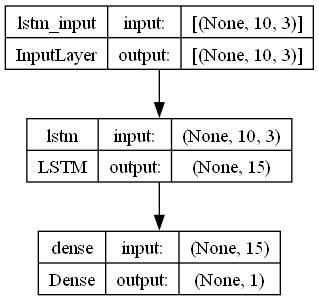

In [9]:
plot_model(model_petr_1, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

<a name='ana'></a>
###[2] 10-10-10-1 --- r = 10, p = 10 e Relu / Levenberg-Marquardt

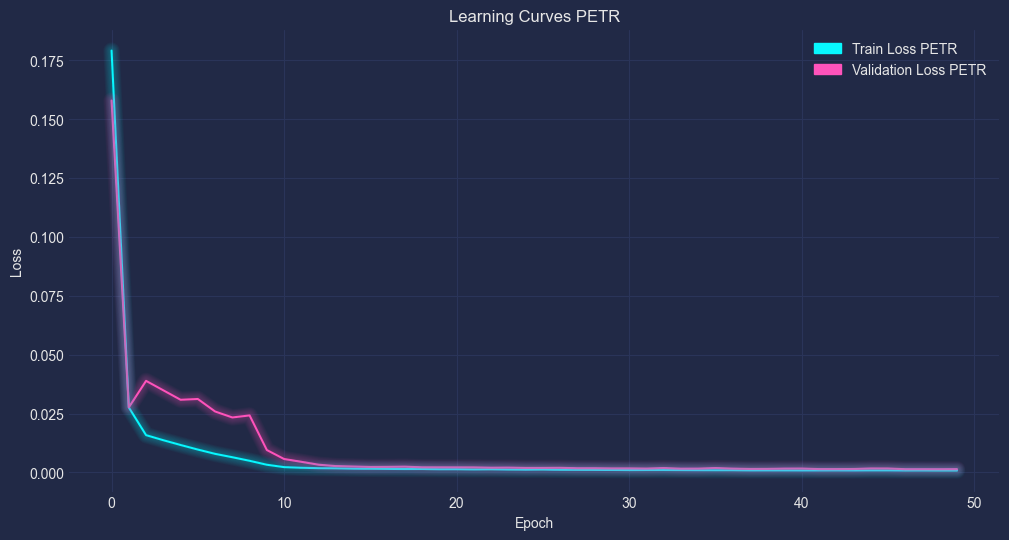

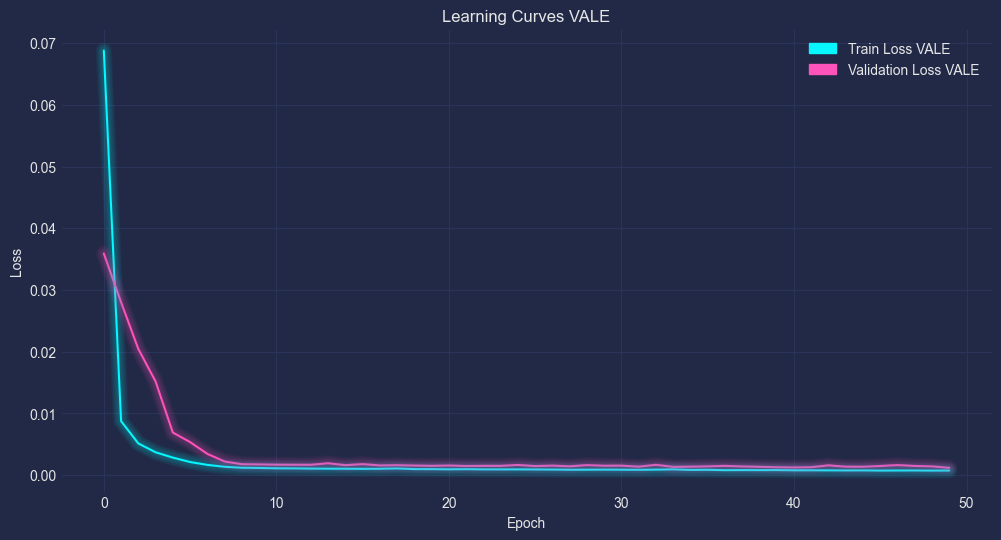

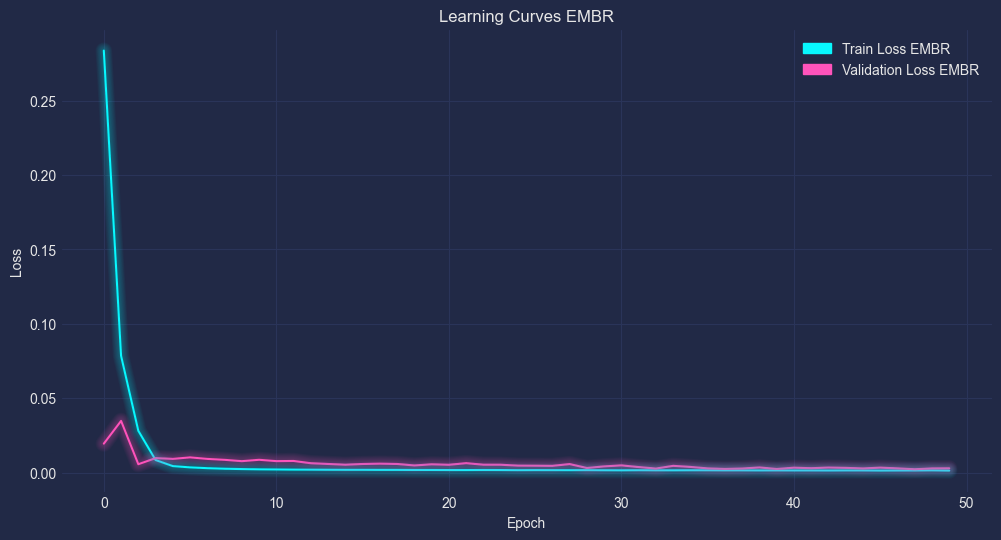

In [10]:
# Renamed variables
r_2 = 10
p_2 = 10

# Função para criar amostras NARMAX
def create_narmax_samples_2(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i+sequence_length])
        y.append(data[i+sequence_length])
    return np.array(X), np.array(y)

# Função para criar um modelo NARMAX
def create_narmax_model_2(r, p, sequence_length, num_features):
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(r, activation='relu', input_shape=(sequence_length, num_features)),
        tf.keras.layers.Dense(p, activation='relu'),
        tf.keras.layers.Dense(1, activation='relu')
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

# Função para treinar um modelo NARMAX e plotar as learning curves
def train_narmax_model_with_learning_curves_2(model, X_train, y_train, X_test, y_test, num_epochs=50, label=''):
    history = model.fit(X_train, y_train, epochs=num_epochs, batch_size=32, validation_data=(X_test, y_test), verbose=0)
    
    # Plotar as learning curves
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='Train Loss ' + label)
    plt.plot(history.history['val_loss'], label='Validation Loss ' + label)
    mplcyberpunk.make_lines_glow()
    plt.title('Learning Curves ' + label)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    train_patch = mpatches.Patch(color='#08F7FE', label='Train Loss '+ label)
    validation_patch = mpatches.Patch(color='#FE53BB', label='Validation Loss '+ label)
    plt.legend(handles=[train_patch, validation_patch])
    plt.show()

# Função para fazer previsões
def make_predictions_2(model, last_10_days, num_predictions):
    predicted_data = []
    for _ in range(num_predictions):
        prediction_petr = model[0].predict(np.array([last_10_days]), verbose=0)[0][0]
        prediction_embr = model[2].predict(np.array([last_10_days]), verbose=0)[0][0]
        prediction_vale = model[1].predict(np.array([last_10_days]), verbose=0)[0][0]
        prediction = [prediction_petr, prediction_embr, prediction_vale]
        predicted_data.append(prediction)
        last_10_days = np.concatenate((last_10_days[1:], [prediction]), axis=0)
    return predicted_data


# Combine os dados de fechamento em um único array (substitua pelas suas próprias variáveis)
combined_data_2 = np.column_stack((petr_close, vale_close, embr_close))

# Normalização dos dados
scaler_2 = MinMaxScaler()
normalized_data_2 = scaler_2.fit_transform(combined_data_2)

# Dividir os dados em treinamento e teste
train_size_2 = int(0.8 * normalized_data_2.shape[0])
train_data_2 = normalized_data_2[:train_size_2]
test_data_2 = normalized_data_2[train_size_2:]

# Defina o comprimento da sequência para a amostragem NARMAX
sequence_length_2 = 10

# Crie amostras NARMAX para treinamento e teste
X_train_2, y_train_2 = create_narmax_samples_2(train_data_2, sequence_length_2)
X_test_2, y_test_2 = create_narmax_samples_2(test_data_2, sequence_length_2)

# Crie e treine os modelos NARMAX para PETR, VALE e EMBR com learning curves
model_petr_2 = create_narmax_model_2(r_2, p_2, sequence_length_2, normalized_data_2.shape[1])
train_narmax_model_with_learning_curves_2(model_petr_2, X_train_2, y_train_2[:, 0], X_test_2, y_test_2[:, 0], label='PETR')

model_vale_2 = create_narmax_model_2(r_2, p_2, sequence_length_2, normalized_data_2.shape[1])
train_narmax_model_with_learning_curves_2(model_vale_2, X_train_2, y_train_2[:, 1], X_test_2, y_test_2[:, 1], label='VALE')

model_embr_2 = create_narmax_model_2(r_2, p_2, sequence_length_2, normalized_data_2.shape[1])
train_narmax_model_with_learning_curves_2(model_embr_2, X_train_2, y_train_2[:, 2], X_test_2, y_test_2[:, 2], label='EMBR')

# Previsão dos próximos 90 dias para PETR, VALE e EMBR
last_10_days_2 = normalized_data_2[-sequence_length_2:, :]

predicted_2 = make_predictions_2([model_petr_2,
                              model_vale_2,
                              model_embr_2],
                              last_10_days_2, 90)

# Imprima as previsões
petr_predictions_2 = []
embr_predictions_2 = []
vale_predictions_2 = []

for i in predicted_2:
    petr_predictions_2.append(i[0] * (np.max(petr_close) - np.min(petr_close)) + np.min(petr_close))
    embr_predictions_2.append(i[2] * (np.max(embr_close) - np.min(embr_close)) + np.min(embr_close))
    vale_predictions_2.append(i[1] * (np.max(vale_close) - np.min(vale_close)) + np.min(vale_close))

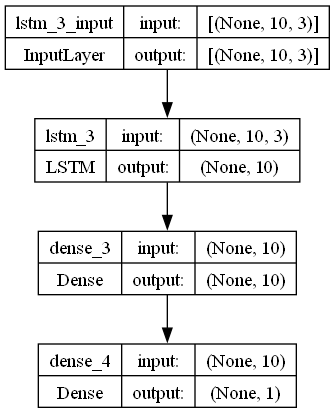

In [11]:
plot_model(model_petr_2, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

<a name='ana'></a>
###[3] 10-10-10-3 --- r=10 , p=10, relu / Resilient Backpropapation

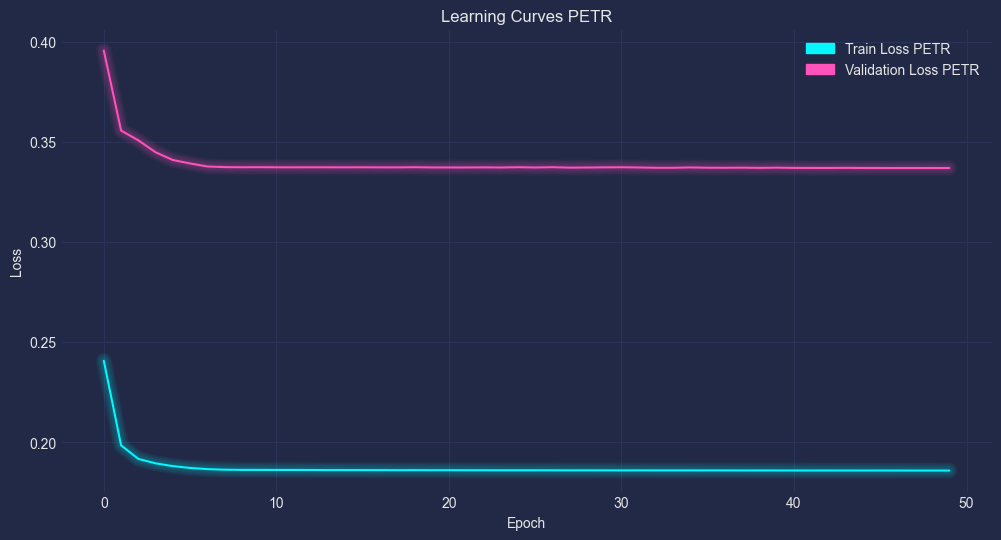

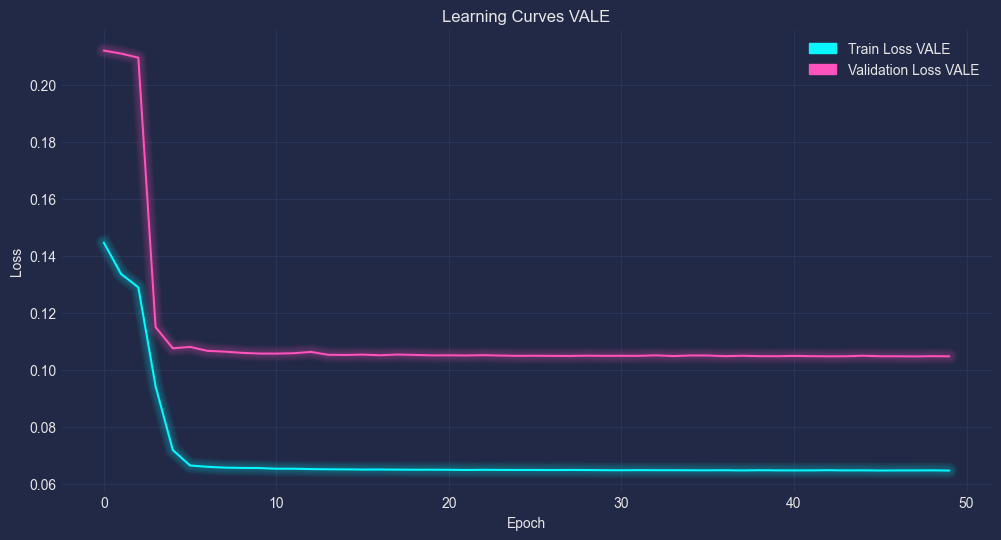

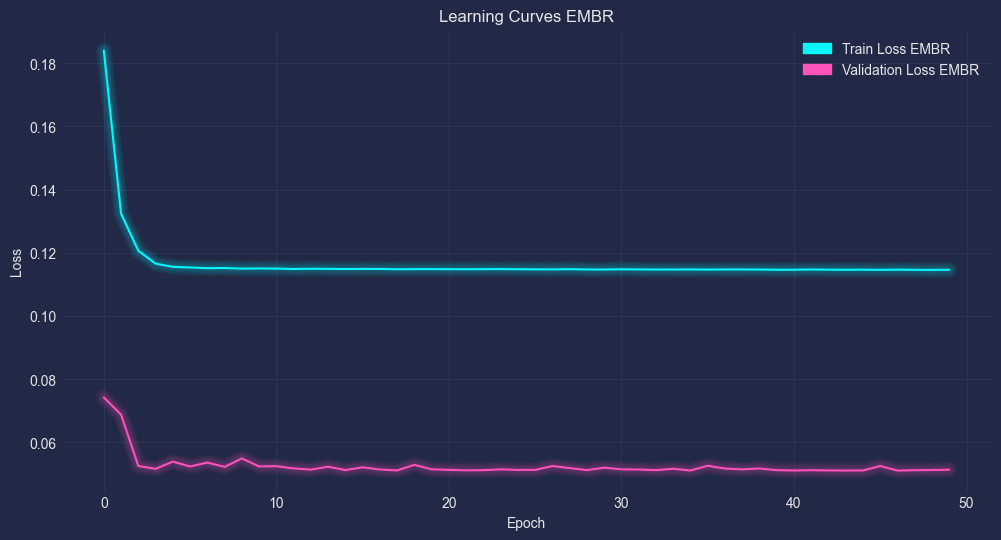

In [12]:
# Renamed variables
r_3 = 10
p_3 = 10

# Função para criar amostras NARMAX
def create_narmax_samples_3(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i+sequence_length])
        y.append(data[i+sequence_length])
    return np.array(X), np.array(y)

# Função para criar um modelo NARMAX
def create_narmax_model_3(r, p, sequence_length, num_features):
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(r, activation='relu', input_shape=(sequence_length, num_features)),
        tf.keras.layers.Dense(p, activation='relu'),
        tf.keras.layers.Dense(3, activation='relu')
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

# Função para treinar um modelo NARMAX e plotar as learning curves
def train_narmax_model_with_learning_curves_3(model, X_train, y_train, X_test, y_test, num_epochs=50, label=''):
    optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9)
    model.compile(optimizer=optimizer, loss='mse')
    history = model.fit(X_train, y_train, epochs=num_epochs, batch_size=32, validation_data=(X_test, y_test), verbose=0)
    
    # Plotar as learning curves
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='Train Loss ' + label)
    plt.plot(history.history['val_loss'], label='Validation Loss ' + label)
    mplcyberpunk.make_lines_glow()
    plt.title('Learning Curves ' + label)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    train_patch = mpatches.Patch(color='#08F7FE', label='Train Loss '+ label)
    validation_patch = mpatches.Patch(color='#FE53BB', label='Validation Loss '+ label)
    plt.legend(handles=[train_patch, validation_patch])
    plt.show()

#Função para prever
def make_predictions_3(model, last_10_days, num_predictions):
    predicted_data = []
    for _ in range(num_predictions):
        prediction_petr = model[0].predict(np.array([last_10_days]), verbose=0)[0][0]
        prediction_embr = model[2].predict(np.array([last_10_days]), verbose=0)[0][0]
        prediction_vale = model[1].predict(np.array([last_10_days]), verbose=0)[0][0]
        prediction = [prediction_petr, prediction_embr, prediction_vale]
        predicted_data.append(prediction)
        last_10_days = np.concatenate((last_10_days[1:], [prediction]), axis=0)
    return predicted_data

# Combine os dados de fechamento em um único array (substitua pelas suas próprias variáveis)
combined_data_3 = np.column_stack((petr_close, vale_close, embr_close))

# Normalização dos dados
scaler_3 = MinMaxScaler()
normalized_data_3 = scaler_3.fit_transform(combined_data_3)

# Dividir os dados em treinamento e teste
train_size_3 = int(0.8 * normalized_data_3.shape[0])
train_data_3 = normalized_data_3[:train_size_3]
test_data_3 = normalized_data_3[train_size_3:]

# Defina o comprimento da sequência para a amostragem NARMAX
sequence_length_3 = 10

# Crie amostras NARMAX para treinamento e teste
X_train_3, y_train_3 = create_narmax_samples_3(train_data_3, sequence_length_3)
X_test_3, y_test_3 = create_narmax_samples_3(test_data_3, sequence_length_3)

# Crie e treine os modelos NARMAX para PETR, VALE e EMBR usando train_narmax_model_rp_3
model_petr_3 = create_narmax_model_3(r_3, p_3, sequence_length_3, normalized_data_3.shape[1])
train_narmax_model_with_learning_curves_3(model_petr_3, X_train_3, y_train_3[:, 0], X_test_3, y_test_3[:, 0], label='PETR')

model_vale_3 = create_narmax_model_3(r_3, p_3, sequence_length_3, normalized_data_3.shape[1])
train_narmax_model_with_learning_curves_3(model_vale_3, X_train_3, y_train_3[:, 1], X_test_3, y_test_3[:, 1], label='VALE')

model_embr_3 = create_narmax_model_3(r_3, p_3, sequence_length_3, normalized_data_3.shape[1])
train_narmax_model_with_learning_curves_3(model_embr_3, X_train_3, y_train_3[:, 2], X_test_3, y_test_3[:, 2], label='EMBR')


# Previsão dos próximos 90 dias para PETR, VALE e EMBR
last_10_days_3 = normalized_data_3[-sequence_length_3:, :]

predicted_3 = make_predictions_3([model_petr_3,
                              model_vale_3,
                              model_embr_3],
                              last_10_days_3, 90)

# Imprima as previsões
petr_predictions_3 = []
embr_predictions_3 = []
vale_predictions_3 = []

for i in predicted_3:
    petr_predictions_3.append(i[0] * (np.max(petr_close) - np.min(petr_close)) + np.min(petr_close))
    embr_predictions_3.append(i[2] * (np.max(embr_close) - np.min(embr_close)) + np.min(embr_close))
    vale_predictions_3.append(i[1] * (np.max(vale_close) - np.min(vale_close)) + np.min(vale_close))

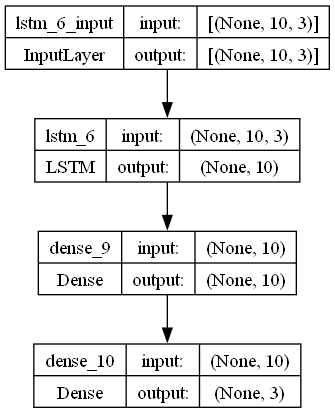

In [13]:
plot_model(model_petr_3, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

<a name='ana'></a>
###[4] 10-25-10 ---  r=25 (RELU) / Polak-Ribiére Conjugate Gradient

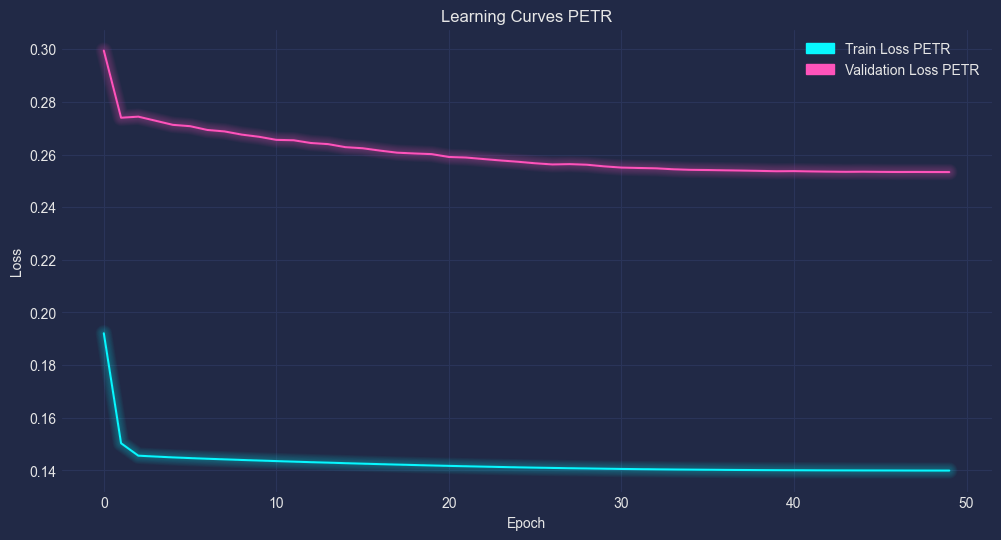

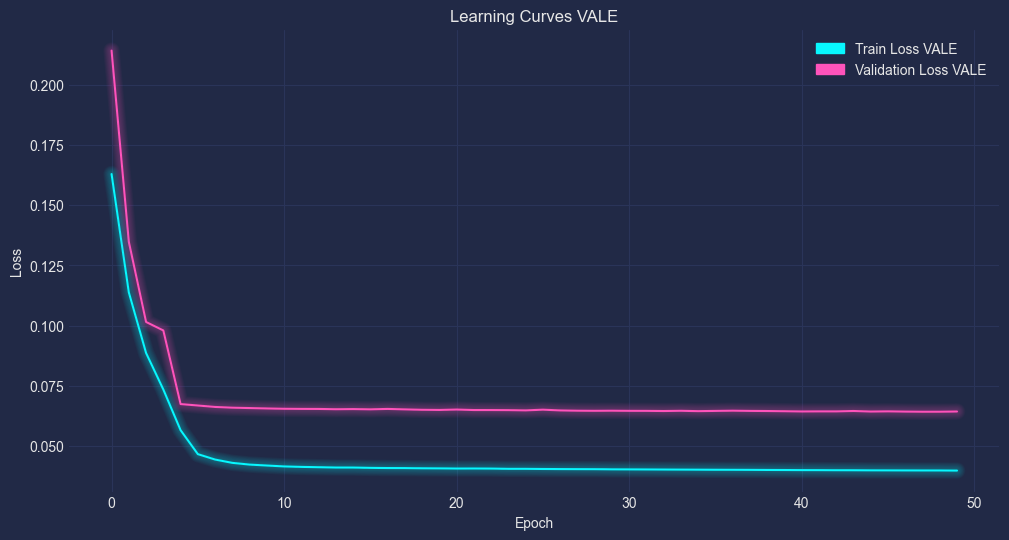

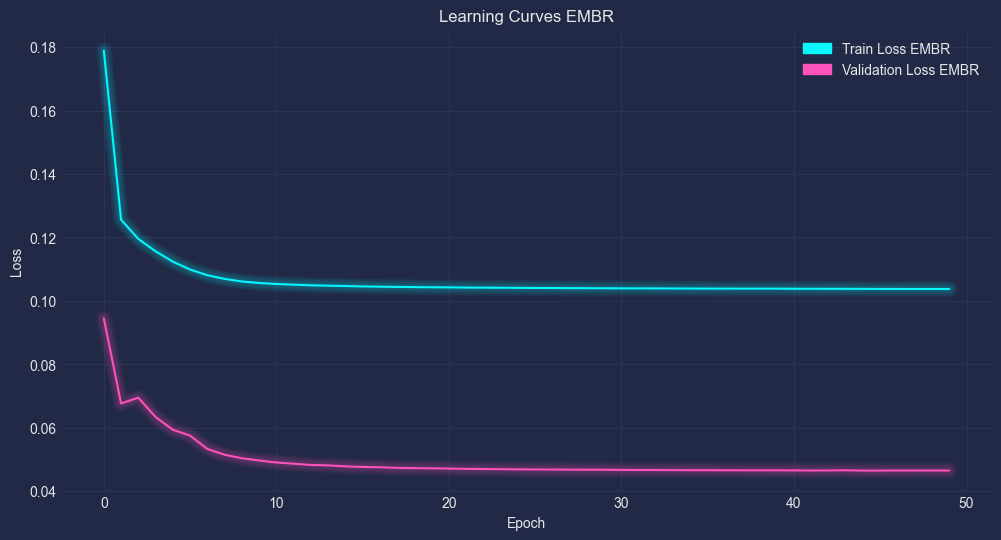

In [14]:
# Renamed variables
r_4 = 25
p_4 = 0

# Função para criar amostras NARMAX
def create_narmax_samples_4(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i+sequence_length])
        y.append(data[i+sequence_length])
    return np.array(X), np.array(y)

# Função para criar um modelo NARMAX
def create_narmax_model_4(r, p, sequence_length, num_features):
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(r, activation='relu', input_shape=(sequence_length, num_features)),
        tf.keras.layers.Dense(10, activation='relu')
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

# Função para treinar um modelo NARMAX e plotar as learning curves
def train_narmax_model_with_learning_curves_4(model, X_train, y_train, X_test, y_test, num_epochs=50, label=''):
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
    model.compile(optimizer=optimizer, loss='mse')
    history = model.fit(X_train, y_train, epochs=num_epochs, batch_size=32, validation_data=(X_test, y_test), verbose=0)
    
    # Plotar as learning curves
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='Train Loss ' + label)
    plt.plot(history.history['val_loss'], label='Validation Loss ' + label)
    mplcyberpunk.make_lines_glow()
    plt.title('Learning Curves ' + label)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    train_patch = mpatches.Patch(color='#08F7FE', label='Train Loss '+ label)
    validation_patch = mpatches.Patch(color='#FE53BB', label='Validation Loss '+ label)
    plt.legend(handles=[train_patch, validation_patch])
    plt.show()
    
# Função para fazer previsões
def make_predictions_4(model, last_10_days, num_predictions):
    predicted_data = []
    for _ in range(num_predictions):
        prediction_petr = model[0].predict(np.array([last_10_days]), verbose=0)[0][0]
        prediction_embr = model[2].predict(np.array([last_10_days]), verbose=0)[0][0]
        prediction_vale = model[1].predict(np.array([last_10_days]), verbose=0)[0][0]
        prediction = [prediction_petr, prediction_embr, prediction_vale]
        predicted_data.append(prediction)
        last_10_days = np.concatenate((last_10_days[1:], [prediction]), axis=0)
    return predicted_data


# Combine os dados de fechamento em um único array (substitua pelas suas próprias variáveis)
combined_data_4 = np.column_stack((petr_close, vale_close, embr_close))

# Normalização dos dados
scaler_4 = MinMaxScaler()
normalized_data_4 = scaler_4.fit_transform(combined_data_4)

# Dividir os dados em treinamento e teste
train_size_4 = int(0.8 * normalized_data_4.shape[0])
train_data_4 = normalized_data_4[:train_size_4]
test_data_4 = normalized_data_4[train_size_4:]

# Defina o comprimento da sequência para a amostragem NARMAX
sequence_length_4 = 10

# Crie amostras NARMAX para treinamento e teste
X_train_4, y_train_4 = create_narmax_samples_4(train_data_4, sequence_length_4)
X_test_4, y_test_4 = create_narmax_samples_4(test_data_4, sequence_length_4)

# Crie e treine os modelos NARMAX para PETR, VALE e EMBR usando train_narmax_model_cgp_4
model_petr_4 = create_narmax_model_4(r_4, p_4, sequence_length_4, normalized_data_4.shape[1])
train_narmax_model_with_learning_curves_4(model_petr_4, X_train_4, y_train_4[:, 0], X_test_4, y_test_4[:, 0], label='PETR')

model_vale_4 = create_narmax_model_4(r_4, p_4, sequence_length_4, normalized_data_4.shape[1])
train_narmax_model_with_learning_curves_4(model_vale_4, X_train_4, y_train_4[:, 1], X_test_4, y_test_4[:, 1], label='VALE')

model_embr_4 = create_narmax_model_4(r_4, p_4, sequence_length_4, normalized_data_4.shape[1])
train_narmax_model_with_learning_curves_4(model_embr_4, X_train_4, y_train_4[:, 2], X_test_4, y_test_4[:, 2], label='EMBR')


# Previsão dos próximos 90 dias para PETR, VALE e EMBR
last_10_days_4 = normalized_data_4[-sequence_length_4:, :]

predicted_4 = make_predictions_4([model_petr_4,
                              model_vale_4,
                              model_embr_4],
                              last_10_days_4, 90)

# Imprima as previsões
petr_predictions_4 = []
embr_predictions_4 = []
vale_predictions_4 = []

for i in predicted_4:
    petr_predictions_4.append(i[0] * (np.max(petr_close) - np.min(petr_close)) + np.min(petr_close))
    embr_predictions_4.append(i[2] * (np.max(embr_close) - np.min(embr_close)) + np.min(embr_close))
    vale_predictions_4.append(i[1] * (np.max(vale_close) - np.min(vale_close)) + np.min(vale_close))

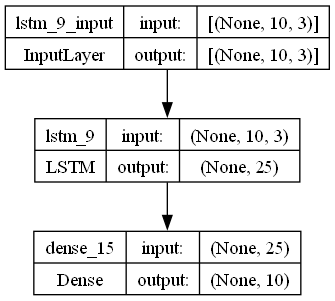

In [15]:
plot_model(model_petr_4, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

<a name='ana'></a>
###[5] 6-25-25-2 --- r=p=25 Tanh / Bayesian Regularization

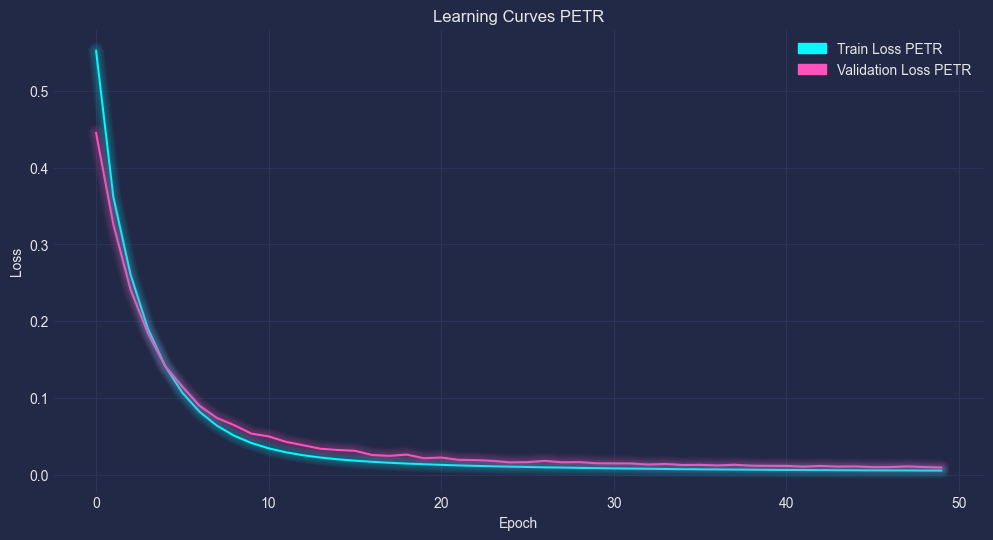

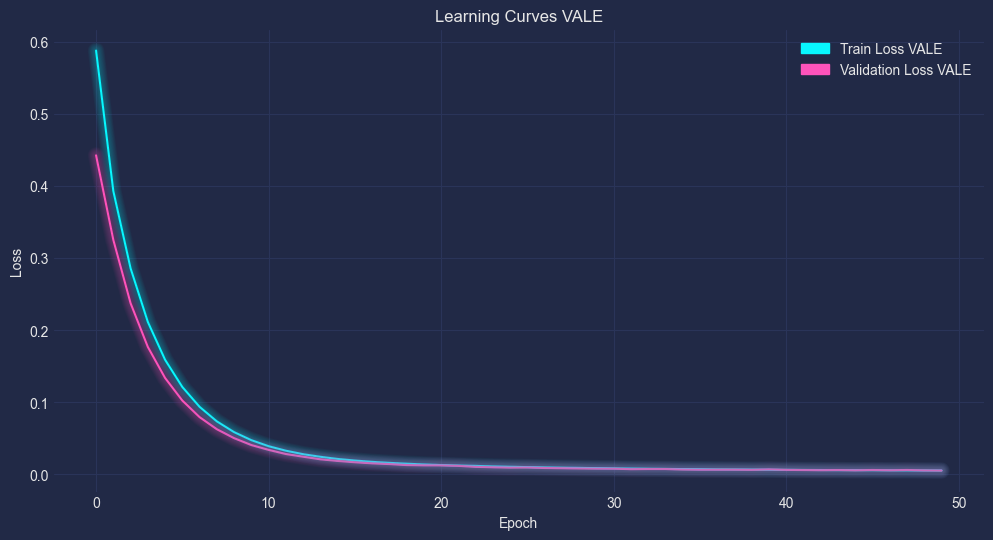

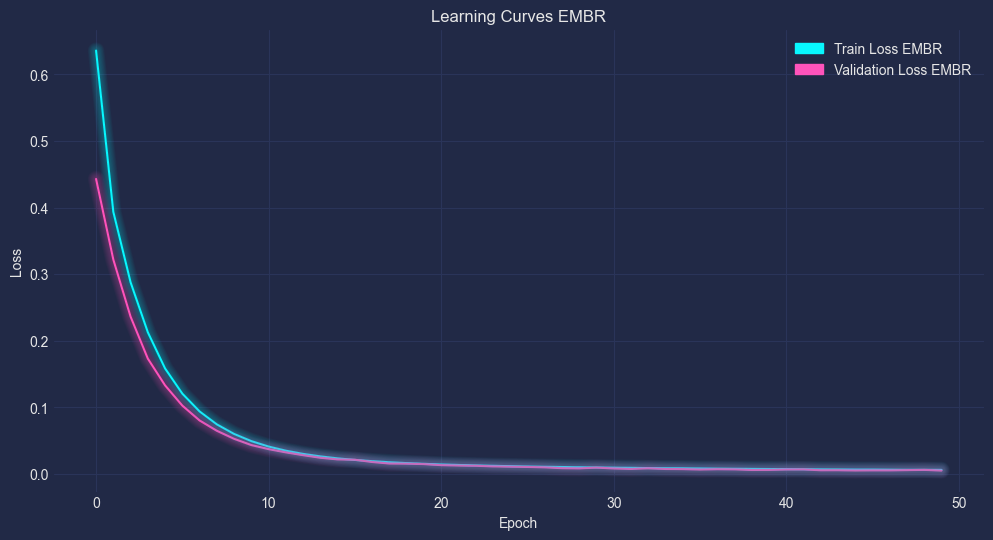

In [16]:
# Renamed variables
r_5 = 25
p_5 = 25

# Função para criar amostras NARMAX
def create_narmax_samples_5(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i+sequence_length])
        y.append(data[i+sequence_length])
    return np.array(X), np.array(y)

# Função para criar um modelo NARMAX com Bayesian Regularization
def create_narmax_model_5(r, p, sequence_length, num_features):
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(r, activation='tanh', input_shape=(sequence_length, num_features),
                             kernel_regularizer=tf.keras.regularizers.L2(0.01),
                             recurrent_regularizer=tf.keras.regularizers.L2(0.01)),
        tf.keras.layers.Dense(p, activation='tanh', kernel_regularizer=tf.keras.regularizers.L2(0.01)),
        tf.keras.layers.Dense(2, activation='tanh')
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

# Função para treinar um modelo NARMAX e plotar as learning curves
def train_narmax_model_with_learning_curves_5(model, X_train, y_train, X_test, y_test, num_epochs=50, label=''):
    model.fit(X_train, y_train, epochs=num_epochs, batch_size=32, validation_data=(X_test, y_test), verbose=0)
    
    # Plotar as learning curves
    plt.figure(figsize=(12, 6))
    plt.plot(model.history.history['loss'], label='Train Loss ' + label)
    plt.plot(model.history.history['val_loss'], label='Validation Loss ' + label)
    mplcyberpunk.make_lines_glow()
    plt.title('Learning Curves ' + label)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    train_patch = mpatches.Patch(color='#08F7FE', label='Train Loss '+ label)
    validation_patch = mpatches.Patch(color='#FE53BB', label='Validation Loss '+ label)
    plt.legend(handles=[train_patch, validation_patch])
    plt.show()

# Função para fazer previsões
def make_predictions_5(model, last_10_days, num_predictions):
    predicted_data = []
    for _ in range(num_predictions):
        prediction_petr = model[0].predict(np.array([last_10_days]), verbose=0)[0][0]
        prediction_embr = model[2].predict(np.array([last_10_days]), verbose=0)[0][0]
        prediction_vale = model[1].predict(np.array([last_10_days]), verbose=0)[0][0]
        prediction = [prediction_petr, prediction_embr, prediction_vale]
        predicted_data.append(prediction)
        last_10_days = np.concatenate((last_10_days[1:], [prediction]), axis=0)
    return predicted_data

# Combine os dados de fechamento em um único array (substitua pelas suas próprias variáveis)
combined_data_5 = np.column_stack((petr_close, vale_close, embr_close))

# Normalização dos dados
scaler_5 = MinMaxScaler()
normalized_data_5 = scaler_5.fit_transform(combined_data_5)

# Dividir os dados em treinamento e teste
train_size_5 = int(0.8 * normalized_data_5.shape[0])
train_data_5 = normalized_data_5[:train_size_5]
test_data_5 = normalized_data_5[train_size_5:]

# Defina o comprimento da sequência para a amostragem NARMAX
sequence_length_5 = 6

# Crie amostras NARMAX para treinamento e teste
X_train_5, y_train_5 = create_narmax_samples_5(train_data_5, sequence_length_5)
X_test_5, y_test_5 = create_narmax_samples_5(test_data_5, sequence_length_5)

# Crie e treine os modelos NARMAX para PETR, VALE e EMBR usando train_narmax_model_br_5
model_petr_5 = create_narmax_model_5(r_5, p_5, sequence_length_5, normalized_data_5.shape[1])
train_narmax_model_with_learning_curves_5(model_petr_5, X_train_5, y_train_5[:, 0], X_test_5, y_test_5[:, 0], label='PETR')

model_vale_5 = create_narmax_model_5(r_5, p_5, sequence_length_5, normalized_data_5.shape[1])
train_narmax_model_with_learning_curves_5(model_vale_5, X_train_5, y_train_5[:, 1], X_test_5, y_test_5[:, 1], label='VALE')

model_embr_5 = create_narmax_model_5(r_5, p_5, sequence_length_5, normalized_data_5.shape[1])
train_narmax_model_with_learning_curves_5(model_embr_5, X_train_5, y_train_5[:, 2], X_test_5, y_test_5[:, 2], label='EMBR')

# Previsão dos próximos 90 dias para PETR, VALE e EMBR
last_10_days_5 = normalized_data_5[-sequence_length_5:, :]

predicted_5 = make_predictions_5([model_petr_5,
                              model_vale_5,
                              model_embr_5],
                              last_10_days_5, 90)

# Imprima as previsões
petr_predictions_5 = []
embr_predictions_5 = []
vale_predictions_5 = []

for i in predicted_5:
    petr_predictions_5.append(i[0] * (np.max(petr_close) - np.min(petr_close)) + np.min(petr_close))
    embr_predictions_5.append(i[2] * (np.max(embr_close) - np.min(embr_close)) + np.min(embr_close))
    vale_predictions_5.append(i[1] * (np.max(vale_close) - np.min(vale_close)) + np.min(vale_close))

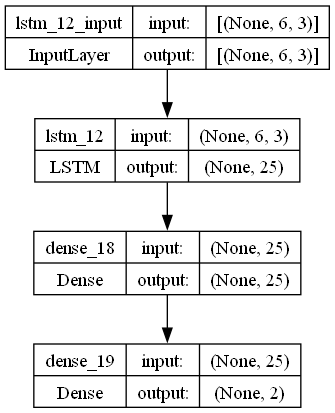

In [17]:
plot_model(model_petr_5, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

<a name='ana'></a>
###[6] 10-25-25-1, r = p = 25, Tanh / RMSprop

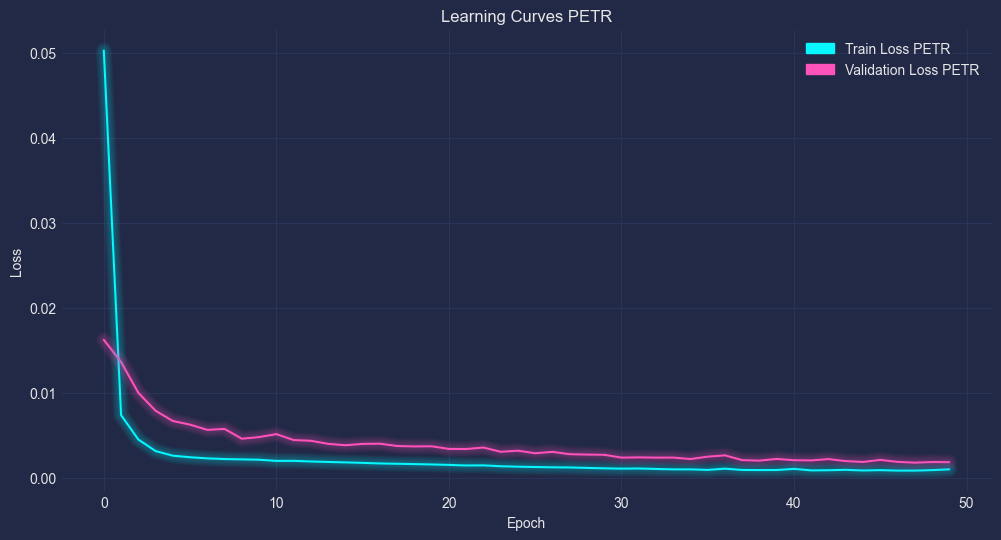

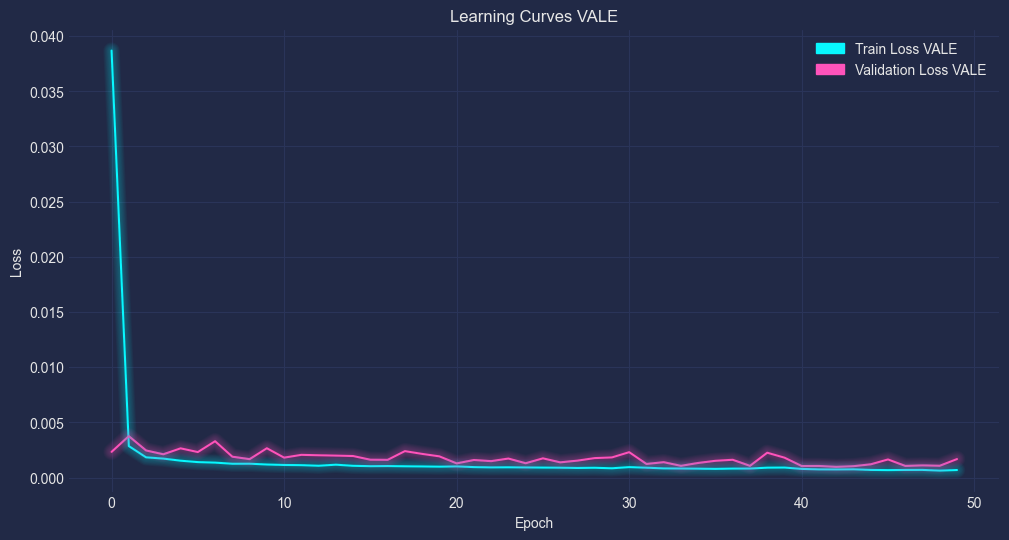

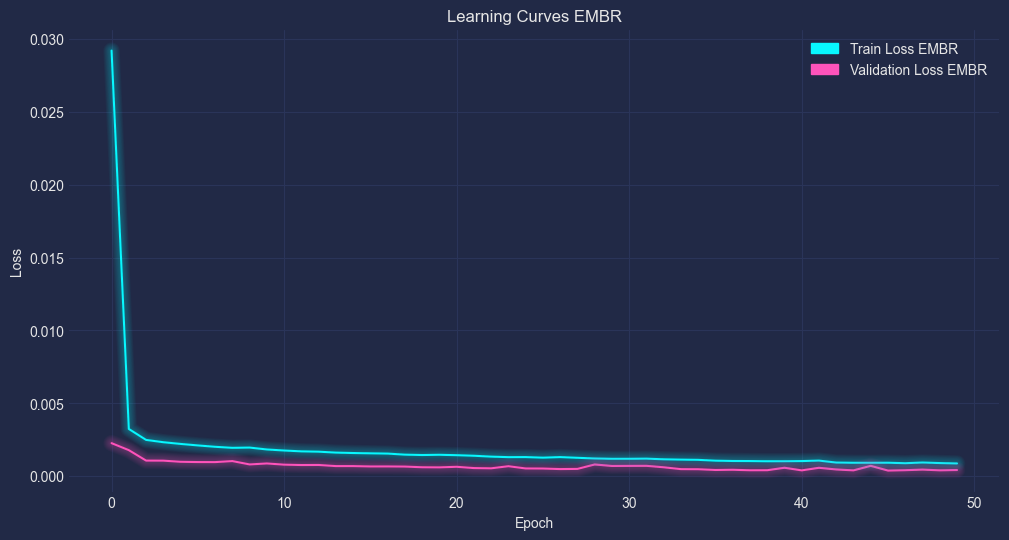

In [18]:
# Renamed variables
r_6 = 25
p_6 = 25

# Função para criar amostras NARMAX
def create_narmax_samples_6(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i+sequence_length])
        y.append(data[i+sequence_length])
    return np.array(X), np.array(y)

# Função para criar um modelo NARMAX
def create_narmax_model_6(r, p, sequence_length, num_features):
    model = tf.keras.Sequential([
    tf.keras.layers.LSTM(r, activation='tanh', input_shape=(sequence_length, num_features)),
    tf.keras.layers.Dense(p, activation='tanh'),
    tf.keras.layers.Dense(1, activation='tanh')
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

# Função para treinar um modelo NARMAX e plotar as learning curves
def train_narmax_model_with_learning_curves_6(model, X_train, y_train, X_test, y_test, num_epochs=50, label=''):
    model.fit(X_train, y_train, epochs=num_epochs, batch_size=32, validation_data=(X_test, y_test), verbose=0)
    
    # Plotar as learning curves
    plt.figure(figsize=(12, 6))
    plt.plot(model.history.history['loss'], label='Train Loss ' + label)
    plt.plot(model.history.history['val_loss'], label='Validation Loss ' + label)
    mplcyberpunk.make_lines_glow()
    plt.title('Learning Curves ' + label)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    train_patch = mpatches.Patch(color='#08F7FE', label='Train Loss '+ label)
    validation_patch = mpatches.Patch(color='#FE53BB', label='Validation Loss '+ label)
    plt.legend(handles=[train_patch, validation_patch])
    plt.show()

# Função para fazer previsões
def make_predictions_6(model, last_10_days, num_predictions):
    predicted_data = []
    for _ in range(num_predictions):
        prediction_petr = model[0].predict(np.array([last_10_days]), verbose=0)[0][0]
        prediction_embr = model[2].predict(np.array([last_10_days]), verbose=0)[0][0]
        prediction_vale = model[1].predict(np.array([last_10_days]), verbose=0)[0][0]
        prediction = [prediction_petr, prediction_embr, prediction_vale]
        predicted_data.append(prediction)
        last_10_days = np.concatenate((last_10_days[1:], [prediction]), axis=0)
    return predicted_data


# Combine os dados de fechamento em um único array (substitua pelas suas próprias variáveis)
combined_data_6 = np.column_stack((petr_close, vale_close, embr_close))

# Normalização dos dados
scaler_6 = MinMaxScaler()
normalized_data_6 = scaler_6.fit_transform(combined_data_6)

# Dividir os dados em treinamento e teste
train_size_6 = int(0.8 * normalized_data_6.shape[0])
train_data_6 = normalized_data_6[:train_size_6]
test_data_6 = normalized_data_6[train_size_6:]

# Defina o comprimento da sequência para a amostragem NARMAX
sequence_length_6 = 10

# Crie amostras NARMAX para treinamento e teste
X_train_6, y_train_6 = create_narmax_samples_6(train_data_6, sequence_length_6)
X_test_6, y_test_6 = create_narmax_samples_6(test_data_6, sequence_length_6)

# Crie e treine os modelos NARMAX para PETR, VALE e EMBR usando train_narmax_model_rp_6
model_petr_6 = create_narmax_model_6(r_6, p_6, sequence_length_6, normalized_data_6.shape[1])
train_narmax_model_with_learning_curves_6(model_petr_6, X_train_6, y_train_6[:, 0], X_test_6, y_test_6[:, 0], label='PETR')

model_vale_6 = create_narmax_model_6(r_6, p_6, sequence_length_6, normalized_data_6.shape[1])
train_narmax_model_with_learning_curves_6(model_vale_6, X_train_6, y_train_6[:, 1], X_test_6, y_test_6[:, 1], label='VALE')

model_embr_6 = create_narmax_model_6(r_6, p_6, sequence_length_6, normalized_data_6.shape[1])
train_narmax_model_with_learning_curves_6(model_embr_6, X_train_6, y_train_6[:, 2], X_test_6, y_test_6[:, 2], label='EMBR')

# Previsão dos próximos 90 dias para PETR, VALE e EMBR
last_10_days_6 = normalized_data_6[-sequence_length_6:, :]

predicted_6 = make_predictions_6([model_petr_6,
                              model_vale_6,
                              model_embr_6],
                              last_10_days_6, 90)

# Imprima as previsões
petr_predictions_6 = []
embr_predictions_6 = []
vale_predictions_6 = []

for i in predicted_6:
    petr_predictions_6.append(i[0] * (np.max(petr_close) - np.min(petr_close)) + np.min(petr_close))
    embr_predictions_6.append(i[2] * (np.max(embr_close) - np.min(embr_close)) + np.min(embr_close))
    vale_predictions_6.append(i[1] * (np.max(vale_close) - np.min(vale_close)) + np.min(vale_close))

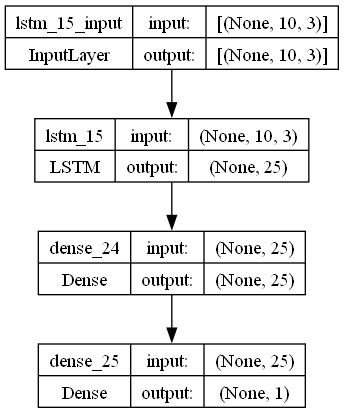

In [19]:
plot_model(model_petr_6, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

## Analisando os resultados

In [20]:
df = pd.DataFrame(petr_predictions_1, index=date_index)
df.columns = ['Petr-pred1']

df['Embr-pred1'] = embr_predictions_1
df['Vale-pred1'] = vale_predictions_1
df['Petr-pred2'] = petr_predictions_2
df['Embr-pred2'] = embr_predictions_2
df['Vale-pred2'] = vale_predictions_2
df['Petr-pred3'] = petr_predictions_3
df['Embr-pred3'] = embr_predictions_3
df['Vale-pred3'] = vale_predictions_3
df['Petr-pred4'] = petr_predictions_4
df['Embr-pred4'] = embr_predictions_4
df['Vale-pred4'] = vale_predictions_4
df['Petr-pred5'] = petr_predictions_5
df['Embr-pred5'] = embr_predictions_5
df['Vale-pred5'] = vale_predictions_5
df['Petr-pred6'] = petr_predictions_6
df['Embr-pred6'] = embr_predictions_6
df['Vale-pred6'] = vale_predictions_6

df = df.reset_index()
df.Date = pd.to_datetime(df.Date, format = '%d/%m/%Y')

df.set_index('Date')

,Petr-pred1,Embr-pred1,Vale-pred1,Petr-pred2,Embr-pred2,Vale-pred2,Petr-pred3,Embr-pred3,Vale-pred3,Petr-pred4,Embr-pred4,Vale-pred4,Petr-pred5,Embr-pred5,Vale-pred5,Petr-pred6,Embr-pred6,Vale-pred6
Date,,,,,,,,,,,,,,,,,,
2023-03-21,27.066199,18.588143,88.287621,25.590274,17.864381,88.911926,26.528290,17.633756,88.409634,26.709238,17.795974,88.542572,27.065658,18.598179,90.113321,26.249262,18.516587,93.277459
2023-03-22,27.194025,18.848920,88.671637,25.259254,18.188880,87.446486,26.276753,17.822225,85.716562,26.665955,17.871534,87.262061,26.983444,18.776011,90.037211,26.596092,19.377978,91.042974
2023-03-23,27.307348,19.119824,88.896300,25.157152,18.389067,87.303712,26.089446,17.819692,84.110084,26.588203,17.951478,86.446795,26.968836,19.003486,89.676583,26.925982,19.897700,90.524376
2023-03-24,27.428237,19.386174,89.077663,25.108450,18.523843,87.059978,25.922502,17.758583,82.912033,26.539374,18.015653,85.824221,27.067230,19.328039,89.437222,27.251044,20.262105,90.969854
2023-03-27,27.578890,19.623611,89.194169,25.079659,18.589157,86.649549,25.768531,17.661341,81.956571,26.500226,18.064194,85.171353,27.197826,19.631924,89.106352,27.607637,20.552604,91.975673
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-07-24,31.905280,21.944226,97.369202,23.876294,14.147878,66.437413,20.600298,9.531356,46.723279,23.485040,12.478988,59.374745,30.364417,20.872841,93.565739,32.170050,23.208539,102.317575
2023-07-25,31.907075,21.943514,97.366040,23.839349,14.091073,66.166725,20.574782,9.498717,46.576557,23.449288,12.432080,59.167485,30.364986,20.872876,93.565860,32.169998,23.208570,102.317696
2023-07-26,31.908757,21.942810,97.362938,23.802296,14.034548,65.898017,20.549991,9.466999,46.433862,23.414116,12.386255,58.964973,30.365508,20.872903,93.565946,32.169950,23.208599,102.317792


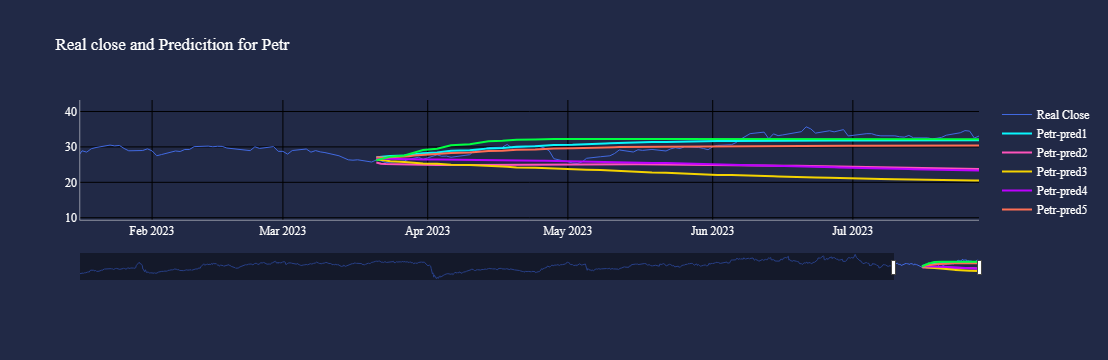

In [21]:
import plotly.io as pio
pio.templates['custom'] = go.layout.Template(
    layout_paper_bgcolor='#212946',
    layout_plot_bgcolor='rgba(0,0,0,0)'
    )
pio.templates.default = 'plotly+custom'

colors = [
    '#08F7FE',
    '#FE53BB',
    '#F5D300',
    '#bd00ff',
    '#ff6e54',
    '#00ff41',
]
indice = 'Petr'
fig = go.Figure()
# Create and style traces
fig.add_trace(go.Scatter(x=companies[indice].index, y=companies[indice].Close, name = 'Real Close',
                         line=dict(color='royalblue', width=1)))

for i in range(0, 6):
    pred = df.loc[:, df.columns.str.startswith(indice)].columns[i]
    fig.add_trace(go.Scatter(x=df.Date, y=df[pred], name=pred,
                            line=dict(color = colors[i])
                            )
                )

fig.layout = dict(
        title=f'Real close and Predicition for {indice}',
        xaxis=dict(
            rangeslider=dict(
                visible = True
            ),
            type='date'
        )
    )

fig.update_layout(
    font_family="Courier Prime",
    font_color="white",
    title_font_family="Courier Prime",
    title_font_color="white",
    legend_title_font_color="white",
)
fig.update_xaxes(showline=True, linewidth=0.5, linecolor='white', gridcolor='black')
fig.update_yaxes(showline=True, linewidth=0.5, linecolor='white', gridcolor='black')

fig.show()